In [154]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, lognorm, multivariate_normal as multinorm
import pandas as pd
from scipy.optimize import minimize

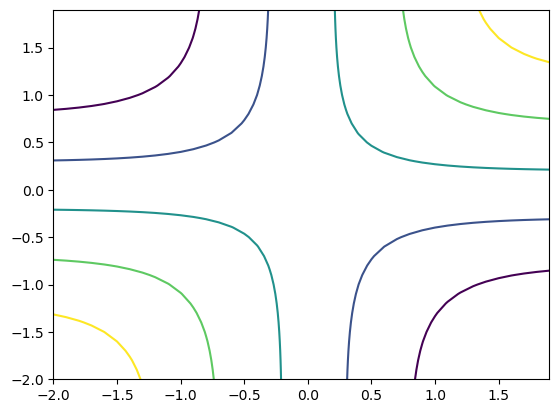

In [45]:
def d(x1, x2, mu = 1, sigma = 1, psame = 0.4):
    a = mu / sigma**2
    return np.log((np.exp(-a*(x1+x2))+np.exp(a*(x1+x2)))/(np.exp(-a*(x1-x2))+np.exp(a*(x1-x2)))) + np.log(psame/(1-psame))
x1, x2 = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1))
# plt.scatter(x1, x2, s = d(x1, x2, 1,1,0.5)> 0)
# plt.show()
plt.contour(x1, x2, d(x1, x2, sigma = 1, psame = 0.4), levels = np.arange(-2, 3))

In [68]:

def lik(x1, x2, s1, s2, sigma = 1):
    return norm.pdf(x1, loc = s1, scale = sigma) * norm.pdf(x2, loc = s2, scale = sigma)
def intgrate(s1, s2, mu, sigma, psame):
    x1, x2 = np.meshgrid(np.arange(-5, 5, 0.01), np.arange(-5, 5, 0.01))
    s1, s2 = mu * s1, mu * s2
    return np.sum(lik(x1, x2, s1, s2, sigma) * (d(x1, x2, mu, sigma, psame) > 0)) * 0.01**2

intgrate(1, 1, 1, 1, 0.5)

0.7313205445015976

In [69]:
def monto(size, s1, s2, mu, sigma, psame):
    x1 = np.random.normal(s1 * mu, sigma, size)
    x2 = np.random.normal(s2 * mu, sigma, size)
    return np.mean(d(x1, x2, mu, sigma, psame) > 0)
monto(10000000, 1, 1, 1, 1, 0.5)

0.7331103

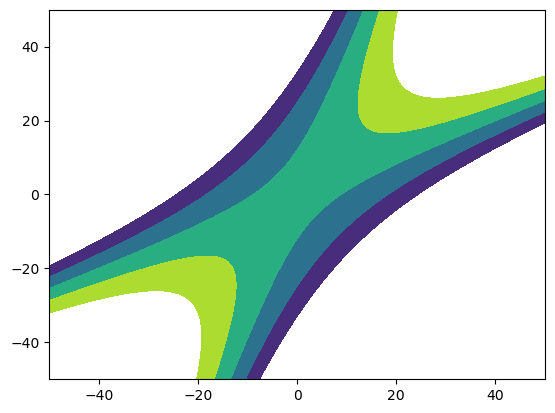

In [109]:
def d(x1, x2, j1 = 1/9, j2=1/100, js = 1/100, psame = 0.5):
    a = j1*j2/(j1+j2+js)
    return 0.5 * np.log(1 + a/js) - 0.5 * a * (j1/(j1+js)*x1**2 + j2/(j2+js) * x2**2 - 2*x1*x2) + np.log(psame/(1-psame))
x1, x2 = np.meshgrid(np.arange(-50, 51), np.arange(-50, 51))
plt.contourf(x1, x2, d(x1, x2), levels = (-2, -1, 0, 1, 2))

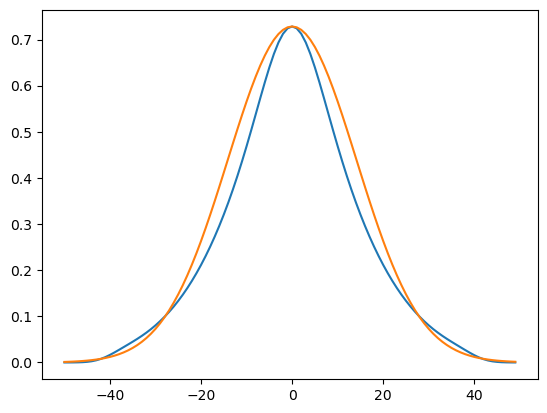

In [112]:
def lik(x1, x2, s1, s2, j1 = 1/9, j2 = 1/100):
    return norm.pdf(x1, loc = s1, scale = j1**(-0.5)) * norm.pdf(x2, loc = s2, scale = j2**(-0.5))
def intgrate(s1, s2, j1 = 1/9, j2 = 1/100, js = 1/100, psame = 0.5):
    x1, x2 = np.meshgrid(np.arange(-40, 40, 0.2), np.arange(-40, 40, 0.2))
    return np.sum(lik(x1, x2, s1, s2, j1, j2) * (d(x1, x2, j1, j2, js, psame) > 0)) * 0.2**2

s_range = np.arange(-50, 50)
plt.plot(s_range, [intgrate(s1, 0) for s1 in s_range])
plt.plot(s_range, [intgrate(0, s2) for s2 in s_range])


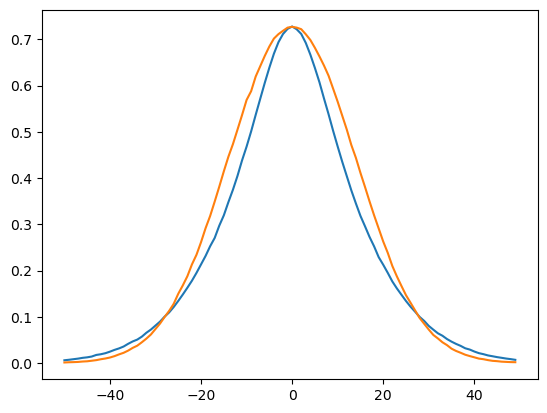

In [114]:
def monto(size, s1, s2, j1 = 1/9, j2 = 1/100, js = 1/100, psame = 0.5):
    x1 = np.random.normal(s1, j1**(-0.5), size)
    x2 = np.random.normal(s2, j2**(-0.5), size)
    return np.mean(d(x1, x2, j1, j2, js, psame) > 0)

s_range = np.arange(-50, 50)
plt.plot(s_range, [monto(100000, s1, 0) for s1 in s_range])
plt.plot(s_range, [monto(100000, 0, s2) for s2 in s_range])

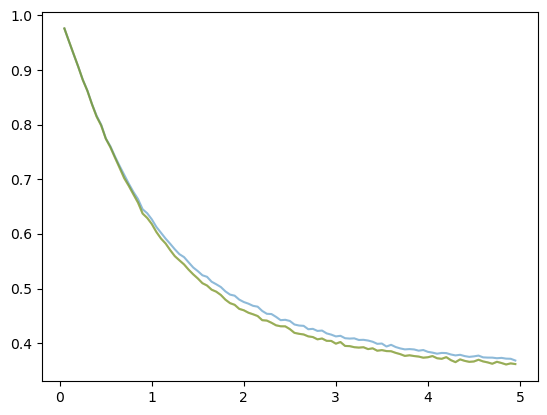

In [261]:
def gen_c(size):
    return np.random.choice(3, size)
def gen_s(c, sigmas):
    s1 = np.random.normal(0, sigmas, c.shape)
    s2 = np.random.normal(0, sigmas, c.shape)
    s1s = np.tile(s1, reps = (3, 1))
    s1s[c, np.arange(len(c))] = s2
    return s1s
def gen_x(s, sigma):
    return np.random.normal(s, sigma)
def gen(size = 10, sigmas = 2, sigma = 1):
    c = gen_c(size)
    s = gen_s(c, sigmas)
    x = gen_x(s, sigma)
    return c, s, x
def inference(x, sigmas, sigma):
    x = x.T
    a1 = sigmas**2 + sigma**2
    a2 = sigmas**2
    mu = np.array([0, 0, 0])
    sigma0 = np.array([[a1, 0, 0], [0, a1, a2], [0, a2, a1]])
    sigma1 = np.array([[a1, 0, a2], [0, a1, 0], [a2, 0, a1]])
    sigma2 = np.array([[a1, a2, 0], [a2, a1, 0], [0, 0, a1]])
    p0 = multinorm.pdf(x, mu, sigma0)
    p1 = multinorm.pdf(x, mu, sigma1)
    p2 = multinorm.pdf(x, mu, sigma2)
    ps = np.stack([p0, p1, p2])
    return ps / ps.sum(0, keepdims=1)
def adhoc1(x):
    return abs(x - x.mean(0, keepdims=1))
def adhoc2(x):
    return -abs(np.array([[0, 1, -1], [1, 0, -1], [1, -1, 0]]) @ x)

size, sigmas, sigma = 100000, 2, 0.1
record, record1, record2 = [], [], []
for sigma in np.arange(0.05, 5, 0.05):
    c, s, x = gen(size, sigmas, sigma)
    a = inference(x, sigmas, sigma)
    a1 = adhoc1(x)
    a2 = adhoc2(x)
    record.append((c.flatten() == a.argmax(0)).mean())
    record1.append((c.flatten() == a1.argmax(0)).mean())
    record2.append((c.flatten() == a2.argmax(0)).mean())
plt.plot(np.arange(0.05, 5, 0.05), record, alpha = 0.5)
plt.plot(np.arange(0.05, 5, 0.05), record1, alpha = 0.5)
plt.plot(np.arange(0.05, 5, 0.05), record2, alpha = 0.5)

In [258]:
len(record)


39

In [253]:
-abs(np.array([[0, 1, -1], [1, 0, -1], [1, -1, 0]]) @ x)

array([[ 6.04212442,  0.6515264 ,  9.08160532, ...,  2.34793687,
         6.70224539,  2.80306713],
       [ 4.48650278,  8.49748284, 10.33180066, ..., 10.82514851,
         5.52568478,  2.97506579],
       [ 1.55562164,  7.84595643,  1.25019535, ...,  8.47721165,
         1.17656061,  0.17199866]])

In [239]:

s1s[np.arange(len(c)), c.flatten()] = s2

ValueError: shape mismatch: value array of shape (2,1) could not be broadcast to indexing result of shape (2,)